# Recommendation System


## Data Description 

- author: name of the person who gave the rating
- country: country the person who gave the rating belongs to
- data: date of the rating
- domain: website from which the rating was taken from
- extract: rating content
- language: language in which the rating was given
- product: name of the product/mobile phone for which the rating was given
- score: average rating for the phone
- score_max: highest rating given for the phone
- source: source from where the rating was taken

In [1]:
from collections import defaultdict
from typing import List

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from surprise import SVD
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import Prediction
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split


%matplotlib inline

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
# https://www.kaggle.com/datasets/dsrivastava2020/recommendation-system

review_1 = pd.read_csv("data/phone_user_review_file_1.csv", encoding="iso-8859-1")
review_2 = pd.read_csv("data/phone_user_review_file_2.csv", encoding="iso-8859-1")
review_3 = pd.read_csv("data/phone_user_review_file_3.csv", encoding="iso-8859-1")
review_4 = pd.read_csv("data/phone_user_review_file_4.csv", encoding="iso-8859-1")
review_5 = pd.read_csv("data/phone_user_review_file_5.csv", encoding="iso-8859-1")
review_6 = pd.read_csv("data/phone_user_review_file_6.csv", encoding="iso-8859-1")

In [4]:
reviews = pd.concat(
    [review_1, review_2, review_3, review_4, review_5, review_6], ignore_index=True
)

In [5]:
reviews.head()


,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
0,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Verizon Wireless,verizonwireless.com,10.0,10.0,As a diehard Samsung fan who has had every Sam...,CarolAnn35,Samsung Galaxy S8
1,/cellphones/samsung-galaxy-s8/,4/28/2017,en,us,Phone Arena,phonearena.com,10.0,10.0,Love the phone. the phone is sleek and smooth ...,james0923,Samsung Galaxy S8
2,/cellphones/samsung-galaxy-s8/,5/4/2017,en,us,Amazon,amazon.com,6.0,10.0,Adequate feel. Nice heft. Processor's still sl...,R. Craig,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl..."
3,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Samsung,samsung.com,9.2,10.0,Never disappointed. One of the reasons I've be...,Buster2020,Samsung Galaxy S8 64GB (AT&T)
4,/cellphones/samsung-galaxy-s8/,5/11/2017,en,us,Verizon Wireless,verizonwireless.com,4.0,10.0,I've now found that i'm in a group of people t...,S Ate Mine,Samsung Galaxy S8


In [6]:
reviews.shape


(1415133, 11)

In [7]:
reviews.columns


Index(['phone_url', 'date', 'lang', 'country', 'source', 'domain', 'score',
       'score_max', 'extract', 'author', 'product'],
      dtype='object')


1.B. Explore, understand the Data and share at least 2 observations.

In [8]:
reviews.dtypes


phone_url     object
date          object
lang          object
country       object
source        object
domain        object
score        float64
score_max    float64
extract       object
author        object
product       object
dtype: object

In [9]:
unique_countries = reviews["country"].unique()
print(f"Unique countries - {unique_countries}")
print(f"Number of unique countries - {len(unique_countries)}")

Unique countries - ['us' 'gb' 'au' 'in' 'il' 'fi' 'it' 'no' 'nl' 'ru' 'cz' 'be' 'se' 'es'
 'br' 'fr' 'ua' 'ca' 'de' 'dk' 'nz' 'tr' 'pl' 'ch' 'pt' 'hu' 'za' 'mx'
 'ae' 'id' 've' 'sg' 'cl' 'ar' 'ec' 'tw' 'co' 'jp' 'uy' 'pe' 'cn' 'kr']
Number of unique countries - 42


In [10]:
def get_info_by_product(df: pd.DataFrame) -> pd.DataFrame:
    review_count = []
    for product, gdf in df.groupby("product"):
        review_count.append(
            {
                "product": product,
                "total_reviews": len(gdf),
                "avg_score": gdf["score"].mean(),
            }
        )
    return pd.DataFrame(review_count)

In [11]:
get_info_by_product(reviews).sort_values("total_reviews", ascending=False)

,product,total_reviews,avg_score
23698,"Lenovo Vibe K4 Note (White,16GB)",5226,7.180253
23697,"Lenovo Vibe K4 Note (Black, 16GB)",4390,7.174032
34801,"OnePlus 3 (Graphite, 64 GB)",4103,8.725323
34802,"OnePlus 3 (Soft Gold, 64 GB)",3563,8.504070
17134,Huawei P8lite zwart / 16 GB,2707,8.447802
...,...,...,...
32662,Nokia Lumia 1020 Windows Smartphone with 41MP ...,1,8.000000
32659,Nokia Lumia 1020 Speck Yellow/Black CandyShell...,1,10.000000
32650,Nokia Lumia 1020 RM-877 AT&T GSM Unlocked 32GB...,1,2.000000
32646,Nokia Lumia 1020 RM-877 32GB 4G LTE Black AT&T...,1,10.000000


In [12]:
print(f"Number of unique products - {len(reviews['product'].unique())}")


Number of unique products - 61314


In [13]:
reviews.describe().T


,count,mean,std,min,25%,50%,75%,max
score,1351644.0,8.00706,2.616121,0.2,7.2,9.2,10.0,10.0
score_max,1351644.0,10.00000,0.000000,10.0,10.0,10.0,10.0,10.0


- There are 42 unique countries from which we've got reviews
- Total of 61324 products have been reviewed
- The mean rating is 8.0 and minimum rating is 0.2 with maximum of 10 for all the reviews
- Lenovo Vibe K4 Note (White,16GB) has the highest number of reviews (But this is without handling the duplicate values)

In [14]:
reviews["score"] = reviews["score"].round()

In [15]:
reviews["score"].sample(10, random_state=2)

1042003    10.0
1261506     8.0
725112      1.0
1179146    10.0
918549      2.0
481083      8.0
202704      NaN
1180718    10.0
541703      9.0
349963     10.0
Name: score, dtype: float64

Since there are some NaN values present converting the dtype to int won't be possible without imputing the missing values or dropping the rows

In [16]:
print("Percentage missing values - ")
df = reviews.isna().sum().round(2)
(df * 100 / reviews.shape[0]).round(2)

Percentage missing values - 


phone_url    0.00
date         0.00
lang         0.00
country      0.00
source       0.00
domain       0.00
score        4.49
score_max    4.49
extract      1.37
author       4.47
product      0.00
dtype: float64

In [17]:
# The missing values in author column can't be imputed
reviews["score"] = reviews["score"].fillna(reviews["score"].median())

In [18]:
sum(reviews.duplicated())


6436

In [19]:
reviews.drop_duplicates(inplace=True)


In [20]:
sampled_reviews = reviews.sample(1_000_000, random_state=612)


In [21]:
len(sampled_reviews)


1000000

In [22]:
# Dropping irrelevant features

df = sampled_reviews[["country", "source", "domain", "score", "author", "product"]]

In [23]:
df.head()


,country,source,domain,score,author,product
430175,in,Amazon,amazon.in,8.0,Vinod Kumar Chengespur,"Lenovo Vibe K4 Note (White,16GB)"
587153,us,Amazon,amazon.com,2.0,Sharon,HTC Desire 816 Black (Virgin mobile) - 5.5 inc...
594786,gb,Amazon,amazon.co.uk,8.0,An Sionnach,Xperia Sony Xperia Z Ultra SIM-free Android Sm...
636378,in,Amazon,amazon.in,2.0,Jomine Jose,Lava Iris X5 (Black)
684532,us,Amazon,amazon.com,8.0,Walter,Sony Xperia L C2104 Unlocked Phone--U.S. Warra...


<Axes: xlabel='total_reviews', ylabel='product'>

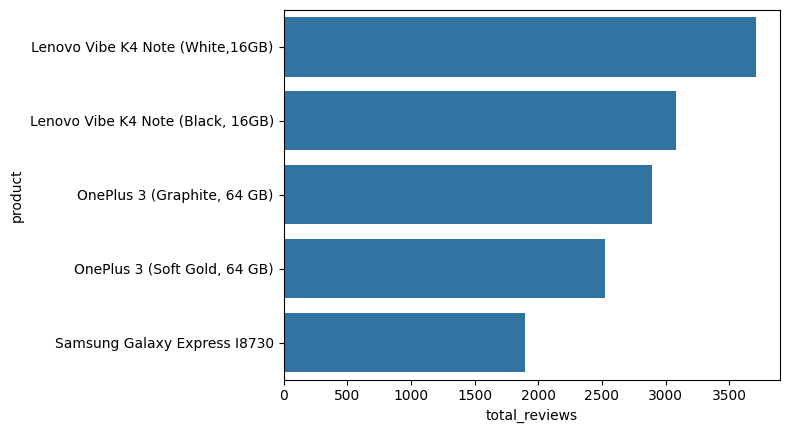

In [24]:
# top five most rated products

sns.barplot(
    get_info_by_product(df).sort_values(by="total_reviews", ascending=False)[0:5],
    y="product",
    x="total_reviews",
)

In [25]:
# products with high rating
get_info_by_product(df).sort_values(by="avg_score", ascending=False)[0:5]

,product,total_reviews,avg_score
0,'Sony Xperia X (F5122) â White â Dual Sim ...,1,10.0
10516,"Elegiant THL 5000 Smartphone 5.0 ""Android4.4 M...",1,10.0
37792,Samsung Galaxy Fame S6810 Unlocked GSM Android...,3,10.0
37782,Samsung Galaxy Fame Lite GT-S6790 - Smartphone...,1,10.0
37776,Samsung Galaxy Fame LITE - Black - Smartphone ...,1,10.0


- It's possible that the product is relatively new or not well-known, so it hasn't had many reviews yet. 
- In this case, the high rating could be due to the fact that the few customers who have tried the product are particularly satisfied, but it could also be a coincidence or a result of selection bias.

In [26]:
reviews_by_author = []
for user, gdf in df.groupby("author"):
    reviews_by_author.append(
        {
            "author": user,
            "avg_score": gdf["score"].mean(),
            "products_reviewed": len(gdf["product"].unique()),
            "total_reviews": len(gdf),
        }
    )

reviews_by_author_df = pd.DataFrame(reviews_by_author)
reviews_by_author_df.head()

,author,avg_score,products_reviewed,total_reviews
0,efef,10.0,1,1
1,!,9.0,1,1
2,!!!!!!!!!!!!!!!!!!!!!!!!!!!!,10.0,1,1
3,"!!!JOSE""ANTONIO""",10.0,1,1
4,!!:. PuNi$heR .:!!,10.0,1,1


<Axes: xlabel='total_reviews', ylabel='author'>

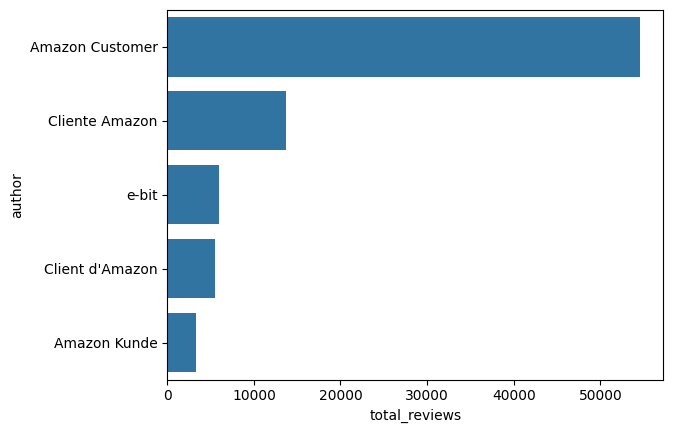

In [27]:
# Top five users with most number of reviews
sns.barplot(
    reviews_by_author_df.sort_values("total_reviews", ascending=False)[0:5],
    y="author",
    x="total_reviews",
)

In this case the user providing most reviews is probably an anonymous 'Amazon Cutomer' 

In [28]:
# first filter products then users
product_counts = df["product"].value_counts()
popular_products = product_counts[product_counts > 50].index
df_popular_products = df[df["product"].isin(popular_products)]
df_popular_products.shape


(556118, 6)

In [29]:
df_popular_products["author"].value_counts()


author
Amazon Customer          40421
Cliente Amazon            6883
e-bit                     4798
Client d'Amazon           2564
Amazon Kunde              2079
                         ...  
manuela rosetti              1
christina rose               1
Mary Alice D.                1
Nils Henning Deitmers        1
Monalisa                     1
Name: count, Length: 347229, dtype: int64

In [30]:
# use df from previous result to filter popular users
user_counts = df_popular_products["author"].value_counts()
prolific_users = user_counts[user_counts > 50].index
df_final = df_popular_products[df_popular_products["author"].isin(prolific_users)]

df_final.shape


(89141, 6)

In [31]:
# Using df from previous cell
get_info_by_product(df_final).sort_values(
    by=["total_reviews", "avg_score"], ascending=False
)[0:5]


,product,total_reviews,avg_score
1388,"Lenovo Vibe K4 Note (White,16GB)",2178,6.979798
1387,"Lenovo Vibe K4 Note (Black, 16GB)",1762,7.051078
2184,"OnePlus 3 (Graphite, 64 GB)",1296,8.530864
2185,"OnePlus 3 (Soft Gold, 64 GB)",1211,8.325351
1389,"Lenovo Vibe K5 (Gold, VoLTE update)",1102,6.557169


In [32]:
# Using the original df
get_info_by_product(df).sort_values(by=["total_reviews", "avg_score"], ascending=False)[
    0:5
]


,product,total_reviews,avg_score
21820,"Lenovo Vibe K4 Note (White,16GB)",3709,7.176597
21819,"Lenovo Vibe K4 Note (Black, 16GB)",3083,7.200130
32017,"OnePlus 3 (Graphite, 64 GB)",2890,8.737716
32018,"OnePlus 3 (Soft Gold, 64 GB)",2522,8.503569
37761,Samsung Galaxy Express I8730,1898,9.002107


Here using 'total_reviews' as first filter and then 'avg_score' as second filter provides the result where more priority is given to products with most number of reviews

A collaborative filtering model using SVD

In [33]:
review_50 = Dataset.load_from_df(
    df_final[["author", "product", "score"]], Reader(rating_scale=(1, 10))
)
train_set, test_set = train_test_split(review_50, test_size=0.25, random_state=612)


In [34]:
svd = SVD(random_state=612)
svd.fit(train_set)

In [35]:
svd_pred = svd.test(test_set)
svd_pred[0:2]

[Prediction(uid='Amazon Customer', iid='Sony Xperia XA Dual (Lime Gold)', r_ui=2.0, est=5.666830421515721, details={'was_impossible': False}),
 Prediction(uid='Cliente Amazon', iid='Samsung G935 Galaxy S7 Edge Smartphone da 32GB, Argento [Italia]', r_ui=10.0, est=8.963796746817252, details={'was_impossible': False})]

In [36]:
# Item Based
knn_item_based = KNNWithMeans(sim_options={"user_based": False})
knn_item_based.fit(train_set)
knn_pred_item = knn_item_based.test(test_set)
knn_pred_item[0:5]

Computing the msd similarity matrix...
Done computing similarity matrix.


[Prediction(uid='Amazon Customer', iid='Sony Xperia XA Dual (Lime Gold)', r_ui=2.0, est=7.1, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid='Cliente Amazon', iid='Samsung G935 Galaxy S7 Edge Smartphone da 32GB, Argento [Italia]', r_ui=10.0, est=8.65, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid='Ð\x94Ð¼Ð¸Ñ\x82Ñ\x80Ð¸Ð¹', iid='Nokia 5230 Navigation Edition', r_ui=8.0, est=8.970051072402065, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid='Cliente Amazon', iid='Samsung A300 Galaxy A3 Smartphone, 16 GB, Bianco [Italia]', r_ui=8.0, est=8.464521950254863, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid='Cliente Amazon', iid='Alcatel One Touch 20-04G Telefono Cellulare, Nero', r_ui=8.0, est=8.5, details={'actual_k': 40, 'was_impossible': False})]

In [37]:
knn_user_based = KNNWithMeans(sim_options={"user_based": True})
knn_user_based.fit(train_set)
knn_pred_user = knn_user_based.test(test_set)
knn_pred_user[0:5]

Computing the msd similarity matrix...
Done computing similarity matrix.


[Prediction(uid='Amazon Customer', iid='Sony Xperia XA Dual (Lime Gold)', r_ui=2.0, est=7.1, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid='Cliente Amazon', iid='Samsung G935 Galaxy S7 Edge Smartphone da 32GB, Argento [Italia]', r_ui=10.0, est=8.65, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid='Ð\x94Ð¼Ð¸Ñ\x82Ñ\x80Ð¸Ð¹', iid='Nokia 5230 Navigation Edition', r_ui=8.0, est=8.881468424416978, details={'actual_k': 22, 'was_impossible': False}),
 Prediction(uid='Cliente Amazon', iid='Samsung A300 Galaxy A3 Smartphone, 16 GB, Bianco [Italia]', r_ui=8.0, est=8.472856699181397, details={'actual_k': 28, 'was_impossible': False}),
 Prediction(uid='Cliente Amazon', iid='Alcatel One Touch 20-04G Telefono Cellulare, Nero', r_ui=8.0, est=8.5, details={'actual_k': 40, 'was_impossible': False})]

In [38]:
rmse_svd = accuracy.rmse(svd_pred)
rmse_item_based = accuracy.rmse(knn_pred_item)
rmse_user_based = accuracy.rmse(knn_pred_user)

RMSE: 2.6844
RMSE: 2.7109
RMSE: 2.6992


In [39]:
print(f"RMSE for SVD - {rmse_svd}")
print(f"RMSE for KNN Item Based - {rmse_item_based}")
print(f"RMSE for KNN User Based - {rmse_user_based}")


RMSE for SVD - 2.684413593198293
RMSE for KNN Item Based - 2.7109202114869935
RMSE for KNN User Based - 2.6992264916825617


In [40]:
print(f" Average rating for SVD model - {np.mean([pred.est for pred in svd_pred])}")
print(
    f" Average rating for KNN Item based model - {np.mean([pred.est for pred in knn_pred_item])}"
)
print(
    f" Average rating for KNN user based model - {np.mean([pred.est for pred in knn_pred_user])}"
)

 Average rating for SVD model - 7.757625353578636
 Average rating for KNN Item based model - 7.786648136379793
 Average rating for KNN user based model - 7.826098584580364


Findings and inferences.

- Lenovo and Samsung Galaxy seems to be most popular and highly rated phone segments.
- RMSE for KNN item based and user based are almost similar.
- Overall data is highly skewed towards _Amazon customers_ from different countries. This may also be because 'Amazon' is the biggest trader for phones in the world. 

In [41]:
knn_pred_item[0:3]

[Prediction(uid='Amazon Customer', iid='Sony Xperia XA Dual (Lime Gold)', r_ui=2.0, est=7.1, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid='Cliente Amazon', iid='Samsung G935 Galaxy S7 Edge Smartphone da 32GB, Argento [Italia]', r_ui=10.0, est=8.65, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid='Ð\x94Ð¼Ð¸Ñ\x82Ñ\x80Ð¸Ð¹', iid='Nokia 5230 Navigation Edition', r_ui=8.0, est=8.970051072402065, details={'actual_k': 40, 'was_impossible': False})]

In [42]:

def get_top_n_recommendations(predictions: List[Prediction], n=5):
    top_n = defaultdict(list) # start with default list
	# Mapping prediction
    for uid, iid, true_rating, estimated_rating, _ in predictions:
        top_n[uid].append((iid, estimated_rating))

    # Post mapping sort within the 
    for uid, user_ratings in top_n.items():
		# sort within user rating for higher estimated rating
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [43]:
top5_recomm = get_top_n_recommendations(knn_pred_item)

In [44]:
top5_recomm['Amazon Customer']

[('Sony Xperia E1 UK SIM-Free Smartphone - Black', 10),
 ('Lenovo Motorola Moto G Smartphone (11,4 cm (4,5 Zoll) HD-Display, 5 Megapixel Kamera, 1,2 GHz Quad-Core-Prozessor, 8 GB interner Speicher, Android 4.3 OS) schwarz',
  10),
 ('LG VX9700 Dare Verizon', 10),
 ('Cubot X9 Unlocked Cell Phone 5.0 inch Octa Core MTK6592 2GB RAM 16GB ROM Android 4.4 (Black)',
  10),
 ('Lenovo Motorola Moto G Smartphone, Display HD 4,5", Processore Qualcomm, Memoria 8 GB, MicroSIM, Android 4.4 OS, Fotocamera da 5 MP, Nero [Germania]',
  10)]

In [45]:
top_5_recomm_df = pd.DataFrame.from_dict(top5_recomm, orient='index')

In [46]:
top_5_recomm_df.sample(10)

,0,1,2,3,4
Gabriele,"(Lenovo Motorola Moto G Smartphone, Display HD...","(Acer Liquid E2 Duo Smartphone, Bianco [Franci...",(Lenovo Motorola Moto G 4G 3 Generazione Smart...,"(Asus ZenFone 2 Smartphone, Schermo da 5.5"" Fu...","(Asus ZenFone 2 Smartphone, Schermo da 5.5"" Fu..."
Max,"(Nokia Lumia 800 Cyan Blue, 10)",(Samsung Galaxy Grand Prime Dual Sim Factory U...,"(Samsung Galaxy S6 Smartphone (5,1 Zoll (12,9 ...","(Huawei Ascend Mate 7 Smartphone, Display IPS ...","(Microsoft Nokia 101 Dual-SIM Handy (4,6 cm (1..."
Tina,(Samsung E1150 Handy (extralange Akkulaufzeit)...,"(HTC Desire Sim Free Mobile Phone - Mocha, 10)",(Microsoft Nokia C7-00 Smartphone (8.89cm (3.5...,"(Nokia 6310i silver (GPRS, Bluetooth, HSCSD, W...","(Huawei P8 Lite Smartphone, Display 5"" IPS, Pr..."
Chris,"(Sharp GX15, 10)",(Sim Free Apple iPhone 5S 16GB Mobile Phone - ...,"(APPLE iPhone 7 Plus - Gold, 32 GB, 9.99717036...","(Nokia 5610 XpressMusic, 9.819557930987013)","(Samsung Galaxy S7 goud, roze / 32 GB, 9.68448..."
Silvia,(LG Electronics GS290 Cookie Fresh Handy (7.6c...,"(Asus ZenFone 2 Selfie Smartphone, 32 GB, Dual...","(Lenovo Motorola Moto X Play Smartphone, 5.5"",...","(LG Nexus 5X Smartphone, Display Touch da 5,2""...","(Samsung Galaxy J5 Smartphone, Bianco [Italia]..."
Tom,(Sim Free Samsung Galaxy S7 Mobile Phone - Bla...,"(Samsung Galaxy S5 White 16GB (Virgin Mobile),...",(Apple iPhone 5s 16GB (ÑÐµÑÐµÐ±ÑÐ¸ÑÑÑÐ¹)...,"(Samsung Galaxy S7, 10)","(Samsung Galaxy S II White, 10)"
ÐÐ¸ÐºÑÐ¾Ñ,"(Samsung S8530 Wave II, 9.39719656655401)","(Samsung S7270 Galaxy Ace 3 (Ð±ÐµÐ»ÑÐ¹), 9.31...","(HTC Nexus One, 9.18843471622974)",(Samsung Galaxy S4 mini GT-I9190 (ÐºÐ¾ÑÐ¸ÑÐ½...,"(Sony Xperia Z1 Compact (ÑÐµÑÐ½ÑÐ¹), 9.1541..."
Nicola,"(Samsung Galaxy S III Smartphone, Bianco [Ital...","(Asus ZenFone 3 Smartphone, Display da 5.2"", M...","(Lenovo Motorola Moto G Smartphone, 4,5 pollic...","(Lenovo Motorola Moto G Smartphone, 4,5 pollic...","(Huawei P9 Lite Smartphone, LTE, Display 5.2''..."
David,(Huawei P8 Grace - Smartphone libre Android (p...,"(APPLE iPhone 7 - Silver, 128 GB, 10)",(LG G2 mini - Smartphone libre Android (Pantal...,(Sim Free Motorola Moto G 4th Generation Mobil...,"(Nokia N70, 10)"
Misafir,"(Vodafone (69) 945, 9.0)","(Vodafone (69) 555, 9.0)","(Vodafone (69) 858 Smart, 9.0)","(Samsung (936) Galaxy Ace S5830I, 9.0)","(Samsung (936) Galaxy Ace S5830I, 9.0)"


Other techniques (Example: cross validation) to get better results.

In [47]:
# SVD 
svd_cv = cross_validate(svd, review_50, measures=["RMSE"], cv=5, verbose=False)
print(f"Mean SVD CV score - {svd_cv['test_rmse'].mean()}")
svd_cv

Mean SVD CV score - 2.6860568793861557


{'test_rmse': array([2.65846758, 2.69282985, 2.69573008, 2.68912433, 2.69413256]),
 'fit_time': (0.3931119441986084,
  0.2517261505126953,
  0.2579822540283203,
  0.2542579174041748,
  0.2599048614501953),
 'test_time': (0.03076624870300293,
  0.03050518035888672,
  0.08492517471313477,
  0.030178070068359375,
  0.03051924705505371)}

In [48]:
# KNN Item based

# by default the n_jobs=1 and KNN Item based takes more time we we're setting the n_jobs=4 (alternate is to use multiprocessing.cpu_count())
knn_item_based_cv = cross_validate(knn_item_based, review_50, measures=["RMSE"], cv=5, verbose=False, n_jobs=4)
print(f"Mean KNN Item based CV score - {knn_item_based_cv['test_rmse'].mean()}")
knn_item_based_cv

Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Mean KNN Item based CV score - 2.7034785695034125


{'test_rmse': array([2.71740814, 2.70871256, 2.69455071, 2.68213688, 2.71458456]),
 'fit_time': (6.812378883361816,
  6.819812774658203,
  6.837608814239502,
  6.852417945861816,
  5.789396047592163),
 'test_time': (54.072301149368286,
  53.350480794906616,
  53.1910982131958,
  53.395660638809204,
  40.302135944366455)}

In [49]:
knn_user_based_cv = cross_validate(knn_user_based, review_50, measures=["RMSE"], cv=5, verbose=False)
print(f"Mean KNN User based CV score - {knn_user_based_cv['test_rmse'].mean()}")
knn_user_based_cv

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Mean KNN User based CV score - 2.6958854561897327


{'test_rmse': array([2.70956412, 2.70799096, 2.68482091, 2.6690204 , 2.70803089]),
 'fit_time': (0.09882593154907227,
  0.09842419624328613,
  0.09642386436462402,
  0.09922504425048828,
  0.09835314750671387),
 'test_time': (0.8785512447357178,
  0.7304089069366455,
  0.7494268417358398,
  0.7340688705444336,
  0.7913968563079834)}

- Popularity based recommendation systems are well-suited to a number of business scenarios where there is limited user data or where personalized recommendations are not necessary.

- Businesses for which the content is the product can easily use the most popularity based recommendation system since they're a a good way to highlight the most popular or trending content

- New businesses or businesses with niche market which typically might not have enough user data to build CF based recommendation system can benefit from popularity based.

- Scenarious where products that are low-cost or have a short lifespan, it may not be worth the investment to build complex recommendation systems.

**CF based Recommendation Systems**

- Collaborative filtering (CF) based recommendation systems are particularly useful in situations where a business wants to recommend products or services to customers based on their preferences and past behavior.

- CF algorithms work by analyzing patterns in user behavior and identifying other users who have similar preferences. This allows the system to recommend items that have been positively reviewed by users with similar tastes, even if the current user has not explicitly expressed an interest in that item.

- Businesses such as streaming services, E-Commerce and social networking site benefit from CF based recommendation systems. 

- They're not particularly useful in business which don't have much data but want to provide recommendations becuase CF based recommendation systems suffer from cold-start and sparsity problem.

- They can become computationally expensive and hard to scale. ROI need to be taken into cosidering in such scenarios

Possible methods which can further improve the recommendation for different users

- We can try Hybrid systems can combine multiple recommendation methods to provide better recommendations. 
	- For example, combining collaborative and content based filterin.
- There is also contextual recommendations which can take into account the user's current context, such as their location (in this case country), and device they use, to provide more personalized recommendations
- Having the phone's configuration like the Megapixels of the camera, processor speed and operating system can be helpful here for more accurate recommendations.